<h1>Loading relevant python libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

import seaborn as sns
sns.set(style="ticks")

<h3> Versions of python/keras used in the project

In [2]:
import keras
print(keras.__version__)

Using TensorFlow backend.


1.1.0


In [3]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


<h3> Loading the sample data frame

In [4]:
df = pd.read_excel('Harrow_NO2_timeseries.xls.xls')
df['measurementdategmt'] = pd.to_datetime(df['measurementdategmt'])

In [5]:
df = df.sort('measurementdategmt')

C:\Users\arumyantseva\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


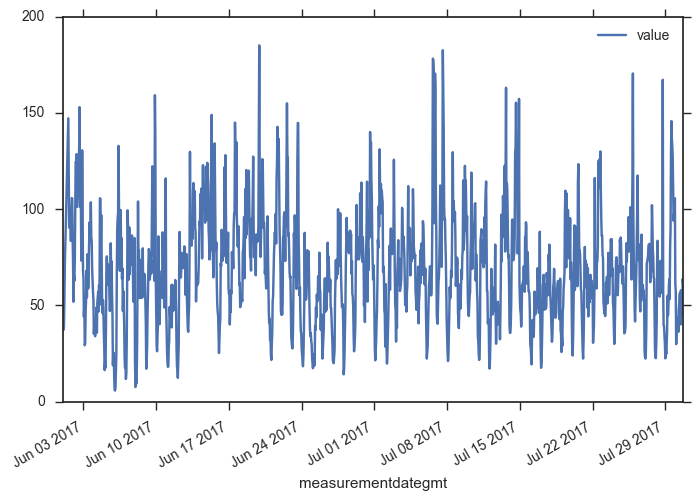

In [6]:
df.plot(x = 'measurementdategmt', y = 'value')


In [7]:
len(df)

1418

## Time series forecast test drive

In [28]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epochs, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
	
	hist = model.fit(X, y, nb_epoch=nb_epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_split=0.33)

	return model, hist
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 


In [29]:
# load dataset
series = df['value'][0:1400] 

In [30]:
# transform data to be stationary
raw_values = series.values

In [31]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(raw_values, 4)
supervised_values = supervised.values

In [32]:
# split data into train and test-sets
train, test = supervised_values[0:-1350], supervised_values[-200:]

In [33]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [34]:
# fit the model
lstm_model, hist = fit_lstm(train_scaled, 1, 3, 4)

In [35]:
hist.history['loss']

[0.27396444712455076, 0.25974894080498029, 0.23636112402208243]

In [36]:
df1= pd.DataFrame(np.array(hist.history['loss']), columns = ['loss'])

In [37]:
df1

,loss
0,0.273964
1,0.259749
2,0.236361


In [57]:
# serialize model to JSON
model_json = lstm_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("model.h5")

In [58]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	print(X)
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	#yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

[-0.52216216 -0.25189189 -0.47351351 -0.24864865]
Month=1, Predicted=51.113232, Expected=55.700000
[-0.43351351 -0.52216216 -0.25189189 -0.47351351]
Month=2, Predicted=48.032017, Expected=51.500000
[-0.39783784 -0.43351351 -0.52216216 -0.25189189]
Month=3, Predicted=51.982260, Expected=58.000000
[-0.44324324 -0.39783784 -0.43351351 -0.52216216]
Month=4, Predicted=42.039700, Expected=65.800000
[-0.37297297 -0.44324324 -0.39783784 -0.43351351]
Month=5, Predicted=53.903773, Expected=53.700000
[-0.28864865 -0.37297297 -0.44324324 -0.39783784]
Month=6, Predicted=74.083720, Expected=62.600000
[-0.41945946 -0.28864865 -0.37297297 -0.44324324]
Month=7, Predicted=58.090469, Expected=62.800000
[-0.32324324 -0.41945946 -0.28864865 -0.37297297]
Month=8, Predicted=65.131953, Expected=56.500000
[-0.32108108 -0.32324324 -0.41945946 -0.28864865]
Month=9, Predicted=69.866569, Expected=57.200000
[-0.38918919 -0.32108108 -0.32324324 -0.41945946]
Month=10, Predicted=61.188390, Expected=30.500000
[-0.38162

IndexError: index 1400 is out of bounds for axis 0 with size 1400

Test RMSE: 18.168


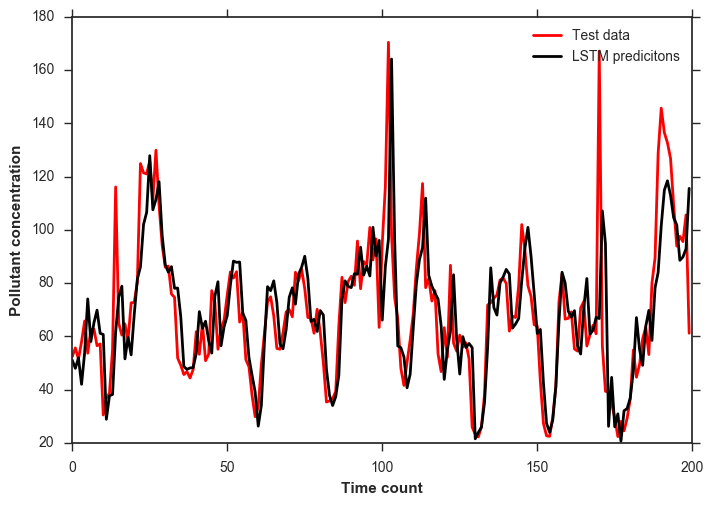

In [59]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-200:], '-r', label = 'Test data', linewidth = 2)
pyplot.plot(predictions, '-k', label = 'LSTM predicitons', linewidth = 2)
pyplot.legend()
pyplot.xlabel('Time count', fontweight = 'bold')
pyplot.ylabel('Pollutant concentration', fontweight = 'bold')
pyplot.show()



In [62]:
from sklearn.metrics import r2_score

In [63]:
r2_score(raw_values[-200:], predictions)

0.53656652170496721